In [1]:
!pip install theano
!pip install pymc3
!pip install arviz

  Created wheel for theano: filename=Theano-1.0.4-cp37-none-any.whl size=2667193 sha256=90b21d4b1a25879e97f1396d4915feee7b2ee9bef7061ff5b28b9f375339c516
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\88\fb\be\483910ff7e9f703f30a10605ad7605f3316493875c86637014
Successfully built theano


In [38]:
import pandas as pd
import numpy as np
import theano
from theano import tensor as tt, shared
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
#import tensorflow as tf
import pymc3 as pm
import arviz as az
from sklearn.metrics import mean_squared_error
floatX = theano.config.floatX
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.7


## Load data and do data normalization

In [2]:
df = pd.read_csv('AAPL.csv')
df.head()

,Unnamed: 0,The Date of this Price,Expiration Date of the Option,Strike Price,Lowest Closing Ask Across All Exchanges,Implied Volatility of the Option,Underlying Price,DGS10,maturity,"C=Call, P=Put_C","C=Call, P=Put_P"
0,0,2012-09-04,2012-09-07,590.0,85.50,0.636391,674.97,1.59,3,1,0
1,4,2012-09-04,2012-09-07,610.0,65.45,0.495483,674.97,1.59,3,1,0
2,5,2012-09-04,2012-09-07,615.0,60.25,0.408294,674.97,1.59,3,1,0
3,6,2012-09-04,2012-09-07,620.0,55.25,0.376411,674.97,1.59,3,1,0
4,7,2012-09-04,2012-09-07,625.0,50.25,0.363375,674.97,1.59,3,1,0


In [3]:
df.drop(['Unnamed: 0', 'The Date of this Price', 'Expiration Date of the Option'], axis = 1, inplace = True)
df.rename(columns = {'Implied Volatility of the Option': 'IV', 'DGS10':'Risk-free interest rate', 'maturity':'Maturity'}, inplace=True)
df.columns.values[1] = "Price"
df['Risk-free interest rate']=df['Risk-free interest rate'].convert_objects(convert_numeric=True)
df.head()

,Strike Price,Price,IV,Underlying Price,Risk-free interest rate,Maturity,"C=Call, P=Put_C","C=Call, P=Put_P"
0,590.0,85.50,0.636391,674.97,1.59,3,1,0
1,610.0,65.45,0.495483,674.97,1.59,3,1,0
2,615.0,60.25,0.408294,674.97,1.59,3,1,0
3,620.0,55.25,0.376411,674.97,1.59,3,1,0
4,625.0,50.25,0.363375,674.97,1.59,3,1,0


In [7]:
df.dtypes

Strike Price               float64
Price                      float64
IV                         float64
Underlying Price           float64
Risk-free interest rate    float64
Maturity                     int64
C=Call, P=Put_C              int64
C=Call, P=Put_P              int64
dtype: object

In [8]:
df.isnull().sum()

Strike Price                  0
Price                         0
IV                            0
Underlying Price              0
Risk-free interest rate    9984
Maturity                      0
C=Call, P=Put_C               0
C=Call, P=Put_P               0
dtype: int64

In [6]:
df.shape

(727050, 8)

In [4]:
df=df.dropna()

In [8]:
df_sample = df.sample(n=10000)

In [9]:
target = df_sample['Price'].values
data = df_sample[['Strike Price', 'IV', 'Underlying Price', 'Risk-free interest rate', 'Maturity', 'C=Call, P=Put_C', 'C=Call, P=Put_P']]
#df.drop(['Price'], axis = 1, inplace = True)

([<matplotlib.axis.YTick at 0x1244905f8>],
 <a list of 1 Text yticklabel objects>)

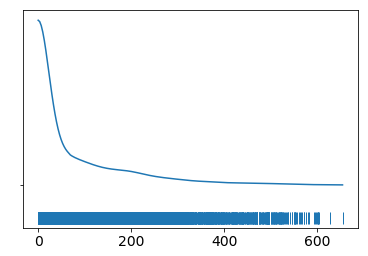

In [39]:
az.plot_kde(target, rug=True)
plt.yticks([0], alpha=0)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=42)

In [11]:
print(X_train.shape)
print(y_train.shape)

(6700, 7)
(6700,)


In [12]:
scaler = preprocessing.Normalizer().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Bayesian Neural Network Model

We define a neural network with two hidden layers of dimensions $H_0$ and $H_1$. With $D$-dimensional input and the neural network uses rectified linear unit activations.<br>Let us denote the parameters of the neural network by $\theta = \{ \mathbf{W}_0, \mathbf{W}_1, \mathbf{W}_2, \mathbf{b}_0, \mathbf{b}_1, \mathbf{b}_2 \}$, and define the prior $p(\theta)$ by setting each component of each parameter to have a standard normal distribution. We then define the likelihood as a normal distribution with fixed variance $\sigma_y^2$:

#### MCMC

In [15]:
D = X_train_scaled.shape[1]
H0 = 10
H1 = 20

#def construct_nn(ann_input, ann_output):
    
init_1_w = np.random.randn(D, H0).astype(floatX)
init_1_b = np.random.randn(H0).astype(floatX)
init_2_w = np.random.randn(H0, H1).astype(floatX)
init_2_b = np.random.randn(H1).astype(floatX)
init_out_w = np.random.randn(H1).astype(floatX)
init_out_b = np.random.randn(1).astype(floatX)

minibatch_x = pm.Minibatch(X_train_scaled, batch_size=100)
minibatch_y = pm.Minibatch(y_train, batch_size=100)
    
BoundNormal = pm.Bound(pm.Normal, lower=0.01, upper=1.)
with pm.Model() as NN_MCMC:
    # Weights and bias from input to hidden layer
    w_0 = pm.Normal('w_0', mu=0, sd=1, shape=(D, H0), testval=init_1_w)
    b_0 = pm.Normal('b_0', mu=0, sd=1, shape=(H0), testval=init_1_b)
        
    # Weights and bias from 1st to 2nd layer
    w_1 = pm.Normal('w_1', mu=0, sd=1, shape=(H0, H1), testval=init_2_w)
    b_1 = pm.Normal('b_1', mu=0, sd=1, shape=(H1), testval=init_2_b)
        
    # Weights from hidden layer to output
    w_2 = pm.Normal('w_2', mu=0, sd=1, shape=(H1), testval=init_out_w)
    b_2 = pm.Normal('b_2', mu=0, sd=1, shape=(1), testval=init_out_b)
        
    # Build neural-network using relu activation function
    hidden1 = tt.nnet.relu(pm.math.dot(minibatch_x,w_0) + b_0)
    hidden2 = tt.nnet.relu(pm.math.dot(hidden1,w_1) + b_1)
    output = pm.math.dot(hidden2,w_2) + b_2
        
    sigma_y = pm.HalfNormal('sd', sigma=1)
    # Likelihood
    out = pm.Normal('out', mu=output, sigma = sigma_y, observed=minibatch_y, total_size=y_train.shape[0])
    
    #step = pm.Metropolis()
    #trace = pm.sample(5000, init='advi', n_init=20000, tune=2000)
    
    #return neural_network

In [18]:
with NN_MCMC:
    trace = pm.sample(5000, init='advi', n_init=30000, tune=8000, cores = 4)
    pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 665.73:  83%|████████▎ | 24999/30000 [1:27:18<17:23,  4.79it/s]   
Convergence achieved at 25000
Interrupted at 24,999 [83%]: Average Loss = 1.8468e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, b_2, w_2, b_1, w_1, b_0, w_0]
Sampling 4 chains: 100%|██████████| 52000/52000 [2:54:01<00:00,  2.05draws/s]  
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.12233418625429228, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.12014915783928917, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.1

We will use ADVI variational inference algorithm which was recently added to PyMC3, and updated to use the operator variational inference (OPVI) framework. This is much faster and will scale better. 

#### Variational Inference

In [13]:
y_tensor = shared(y_train)
x_tensor = shared(X_train_scaled)

In [19]:
D = X_train_scaled.shape[1]
H0 = 10
H1 = 20

#def construct_nn(ann_input, ann_output):
    
init_1_w = np.random.randn(D, H0).astype(floatX)
init_1_b = np.random.randn(H0).astype(floatX)
init_2_w = np.random.randn(H0, H1).astype(floatX)
init_2_b = np.random.randn(H1).astype(floatX)
init_out_w = np.random.randn(H1).astype(floatX)
init_out_b = np.random.randn(1).astype(floatX)
    
BoundNormal = pm.Bound(pm.Normal, lower=0.01, upper=1.)
with pm.Model() as neural_network:
    # Weights and bias from input to hidden layer
    w_0 = pm.Normal('w_0', mu=0, sd=1, shape=(D, H0), testval=init_1_w)
    b_0 = pm.Normal('b_0', mu=0, sd=1, shape=(H0), testval=init_1_b)
        
    # Weights and bias from 1st to 2nd layer
    w_1 = pm.Normal('w_1', mu=0, sd=1, shape=(H0, H1), testval=init_2_w)
    b_1 = pm.Normal('b_1', mu=0, sd=1, shape=(H1), testval=init_2_b)
        
    # Weights from hidden layer to output
    w_2 = pm.Normal('w_2', mu=0, sd=1, shape=(H1), testval=init_out_w)
    b_2 = pm.Normal('b_2', mu=0, sd=1, shape=(1), testval=init_out_b)
        
    # Build neural-network using relu activation function
    hidden1 = tt.nnet.relu(pm.math.dot(x_tensor,w_0) + b_0)
    hidden2 = tt.nnet.relu(pm.math.dot(hidden1,w_1) + b_1)
    output = pm.math.dot(hidden2,w_2) + b_2
        
    sigma_y = pm.HalfNormal('sd', sigma=1)
    # Likelihood
    out = pm.Normal('out', mu=output, sigma = sigma_y, observed=y_tensor, total_size=y_train.shape[0])


In [20]:
map_tensor_batch = {y_tensor: pm.Minibatch(y_train, 100),
                    x_tensor: pm.Minibatch(X_train_scaled, 100)}

Average Loss = 664.41: 100%|██████████| 30000/30000 [1:53:00<00:00,  4.87it/s]   
Finished [100%]: Average Loss = 664.57


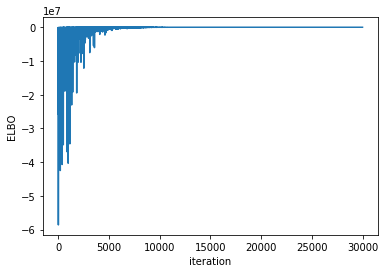

In [21]:
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(method=inference, n=30000, more_replacements=map_tensor_batch)
    
    plt.plot(-inference.hist)
    plt.ylabel('ELBO')
    plt.xlabel('iteration')

In [22]:
trace = approx.sample(1000)
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
w_0__0_0,2.082346,0.295114,0.009967,1.472578,2.627743
w_0__0_1,1.224401,0.447257,0.014199,0.220679,1.999861
w_0__0_2,0.350492,0.634035,0.019379,-0.835236,1.629032
w_0__0_3,-1.858312,0.642736,0.020776,-3.062074,-0.573209
w_0__0_4,0.482584,0.980937,0.029926,-1.338510,2.492515
w_0__0_5,1.273252,0.432709,0.013087,0.474335,2.170221
w_0__0_6,0.372741,0.655853,0.019563,-0.925783,1.596467
w_0__0_7,0.121860,0.815695,0.025608,-1.409078,1.888358
w_0__0_8,-0.290051,0.614675,0.017905,-1.374701,0.983352
w_0__0_9,0.828647,0.310741,0.009533,0.221854,1.408745


In [24]:
y_tensor.set_value(y_test)
x_tensor.set_value(X_test_scaled)

advi_ppc = pm.sample_ppc(trace, 200, neural_network)
advi_pred = np.mean(advi_ppc['out'], axis=0)


100%|██████████| 200/200 [06:50<00:00,  2.03s/it]


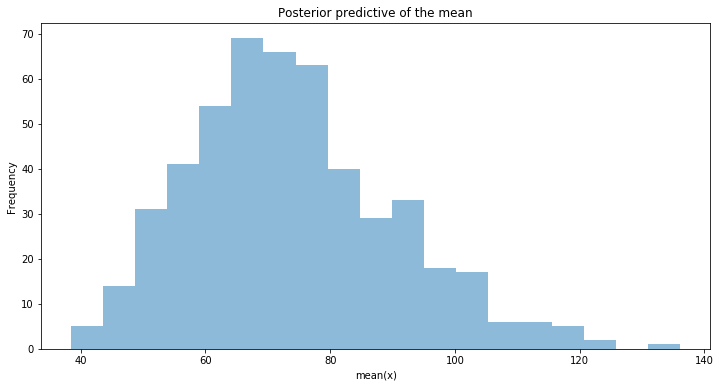

In [51]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in advi_ppc['out']], bins=19, alpha=0.5)
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

In [25]:
prediction_data = pd.DataFrame({'actual': y_test,
                                'error_ADVI':advi_pred-y_test})

RMSE = np.sqrt(np.mean(prediction_data.error_ADVI ** 2))

print(f'RMSE for ADVI predictions = {RMSE:.3f}')

RMSE for ADVI predictions = 106.815


In [37]:
advi_pred[0:5]

array([87.87016457, 53.18206239, 83.43132608, 67.18995291, 75.55911824])

In [36]:
len(advi_ppc['out'][:,0])

200

In [54]:
len(advi_ppc['out'])

500

Average Loss = 7.2135e+05: 100%|██████████| 10000/10000 [37:03<00:00,  4.53it/s] 
Finished [100%]: Average Loss = 7.2159e+05


Wall time: 38min 47s


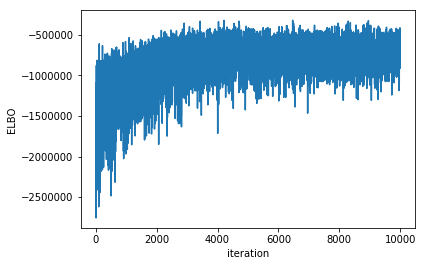

In [24]:
%%time

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=10000, method=inference)
    
    trace = approx.sample(draws=5000)
    
    plt.plot(-inference.hist)
    plt.ylabel('ELBO')
    plt.xlabel('iteration')

Average Loss = 6.619e+05: 100%|██████████| 50000/50000 [3:01:38<00:00,  4.58it/s]   
Finished [100%]: Average Loss = 6.6151e+05


ImportError: ArviZ is not installed. In order to use `plot_trace`:
pip install arviz

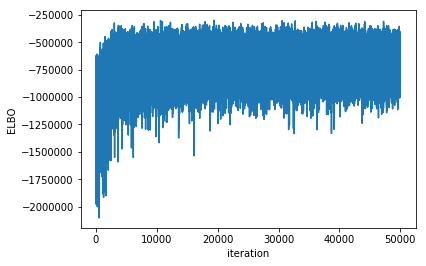

In [17]:
%%time

with neural_network_minibatch:
    inference = pm.ADVI()
    approx = pm.fit(n=50000, method=inference)
    
    trace = approx.sample(draws=5000)
    
    plt.plot(-inference.hist)
    plt.ylabel('ELBO')
    plt.xlabel('iteration')
    
    pm.traceplot(trace)

## Reference: 
&emsp;&emsp;Bayesian Deep Learning https://twiecki.io/blog/2016/06/01/bayesian-deep-learning/ <br>
&emsp;&emsp;Bayesian Regression in PYMC3 using MCMC & Variational Inference https://alexioannides.com/2018/11/07/bayesian-regression-in-pymc3-using-mcmc-variational-inference/<br>
&emsp;&emsp;Scale, Standardize, or Normalize with Scikit-Learn https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 <br>
&emsp;&emsp;The Day my Computer Won the Nobel Prize (Neural Network Option Pricing)  https://medium.com/datadriveninvestor/the-day-my-computer-won-the-nobel-prize-neural-network-option-pricing-d29b4379f1d2 <br>